In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import glob as glob
import os
from importlib import reload
%matplotlib inline
import sys
sys.path.append("modules")
import bedgraph_tools as bgt
import peak_tools as pkt
from collections import defaultdict
import pyBigWig as pw
from matplotlib_venn import venn2
import pysam
from itertools import groupby
from Bio import motifs
import logomaker
from Bio import Align
from Bio.Seq import Seq
%config InlineBackend.figure_format='retina'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors


In [2]:
aligner = Align.PairwiseAligner()


In [3]:
def load_bedgraph(path):
    """
    Load a bedgraph file into a Polars DataFrame.

    Args:
        path (str): Path to the bedgraph file.

    Returns:
        pl.DataFrame: A Polars DataFrame with the bedgraph data.
    """
    return pl.read_csv(
        path,
        separator="\t",
        has_header=False,
        new_columns=["Chromosome", "Start", "End", "Value"],
    )

def average_bgs(path_list, ):
    con = pl.concat([pl.read_parquet(x) for x in path_list])\
    .groupby(['Chromosome', 'Start', 'End']).sum()\
    .with_columns((pl.col('Normalized_Reads')/len(path_list)).alias('mean_norm_reads'),
                  (pl.col('Name')/len(path_list)).alias('mean_raw_reads'),
                  pl.col('Chromosome').cast(str))\
    .sort(by=['Chromosome', 'Start'])

    return con

def load_mot(path, mot_path):
    with open(mot_path) as handle:
        cosensus_mot = motifs.read(handle, "pfm-four-columns").consensus

        # Extract the motif sequences (not specifically used below)
    loaded_loc = pd.read_csv(os.path.join(path, 'fimo.tsv'), delimiter='\t').iloc[:-3,: ]#.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'matched_sequence']]
    seqs = loaded_loc.sort_values(by='score', ascending=False).loc[:, 'matched_sequence']
#     loaded_loc['strand'] = seqs.apply(lambda x: align_mots(cosensus_mot, x, aligner)).values
    return loaded_loc

def process_window_peaks(n_peaks, avbgs, window=200):
    """
    Process windowed peak regions and extract normalized read values.

    Parameters:
    - n_peaks (pd.DataFrame): DataFrame containing peaks with columns ['Chromosome', 'mid_motif_peak', 'strand'].
    - avbgs (pl.DataFrame): Polars DataFrame with columns ['Chromosome', 'Start', 'End', 'Normalized_Reads'].
    - window (int): Window size around the mid_motif_peak (default is 200).

    Returns:
    - list: List of normalized read arrays, adjusted for strand orientation.
    - list: List of tuples with coordinates (Chromosome, Start, End) for each window.
    """
    l = []
    
    for i in n_peaks[['Chromosome', 'middle', 'strand']].values:
        # Initialize an array of zeros with size equal to the window
        a = np.zeros(window)

        # Filter the avbgs DataFrame for matching Chromosome and windowed region
        coords = avbgs.filter(
            (pl.col('Chromosome') == i[0]) &
            (pl.col('Start') >= (int(i[1]) - (window / 2))) &
            (pl.col('End') <= (int(i[1]) + (window / 2)))
        ).select(['Start', 'mean_norm_reads']) \
         .with_columns(pl.col('Start') - (int(i[1]) - (window / 2))) \
         .sort(['Start']) \
         .to_numpy()
        
        # Populate the array with normalized reads
        a[coords[:, 0].astype(int)] = coords[:, 1]

        # Calculate the window coordinates
        coords_window = (i[0], int(i[1]) - (window / 2), int(i[1]) + (window / 2))

        # Reverse the array if the strand is negative
        if i[2] == '+':
            l.append(a)
        else:
            l.append(a[::-1])
    
    return l

def filter_top_quantile(group, quantile=0.9):
    """
    Filters rows in a group where the sum across columns is above the quantile threshold.
    
    Parameters:
        group (pd.DataFrame): Grouped DataFrame.
        quantile (float): The quantile threshold (default 0.9).
        
    Returns:
        pd.DataFrame: Filtered DataFrame with top quantile rows.
    """
    # Compute the sum across all numeric columns per row
    # row_sums = group.loc[:, list(np.arange(75,95).astype(str)) + list(np.arange(105,125).astype(str))].sum(axis=1)
    row_sums = group.loc[:, list(np.arange(200).astype(str))].sum(axis=1)

    # Compute the quantile threshold
    threshold = np.quantile(row_sums, quantile)

    # Return rows that exceed the threshold
    return group[row_sums >= threshold]

def find_gap_length(series, threshold):
    """
    Finds the length of the largest gap in the given series where values are below a threshold.

    Parameters:
    series (pd.Series): The mean signal data.
    threshold (float): The value below which the signal is considered absent.

    Returns:
    int: Length of the largest contiguous gap.
    """
    below_threshold = series < threshold  # Boolean mask where values are below the threshold
    gap_lengths = []  # Store lengths of gaps
    current_length = 0

    for is_below in below_threshold:
        if is_below:
            current_length += 1
        else:
            if current_length > 0:
                gap_lengths.append(current_length)
                current_length = 0

    if current_length > 0:  # Catch gap at the end
        gap_lengths.append(current_length)

    return max(gap_lengths, default=0)
def align_mots(ref, seq2, aligner=aligner):
    aligned_F = aligner.align(ref, seq2)
    aligned_R = aligner.align(ref, Seq(seq2).reverse_complement())
    
    if aligned_F.score >= aligned_R.score:
        return "+"
    else:
        return "-"
    
def compute_footprint_lengths(x, y, thresholds):
    """
    Compute footprint lengths for multiple percentage thresholds.
    
    Parameters:
        x (array-like): X-values (time or index)
        y (array-like): Y-values (signal intensity)
        thresholds (list): List of percentage drop values (e.g., [0.05, 0.1, 0.5])

    Returns:
        footprint_lengths (dict): Dictionary with thresholds as keys and footprint lengths as values.
    """
    # Interpolation function
    interp_func = interp1d(x, y, kind='linear')

    # Generate more dense x values for interpolation
    window = 600
    x_dense = np.linspace(min(x), max(x), window)
    y_dense = interp_func(x_dense)  # Interpolated y values

    # Find Peak
    peak_index = int(window/2)
    peak_x = x_dense[peak_index]
    peak_y = y_dense[peak_index]

    footprint_lengths = {}

    for threshold in thresholds:
        threshold_value = threshold * peak_y  # Compute threshold level

        # Find left and right drop-off points safely
        left_indices = np.where(y_dense[:peak_index] <= threshold_value)[0]
        right_indices = np.where(y_dense[peak_index:] <= threshold_value)[0]

        left_x = x_dense[left_indices[-1]] if len(left_indices) > 0 else None
        right_x = x_dense[right_indices[0] + peak_index] if len(right_indices) > 0 else None

        # Compute footprint length if both sides exist
        footprint_length = right_x - left_x if left_x is not None and right_x is not None else None

        footprint_lengths[threshold] = footprint_length

    return footprint_lengths



In [4]:
nmeta = pd.read_parquet('sample_metadata_20250211.parquet')
bgs = nmeta.filter(regex='dbd|lbd$|lig', axis=0).filter(regex='nmumg', axis=0).loc[:, ['NormBG']].T.to_dict()
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_cluster_parsed/',
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_cluster_parsed/', ]

motd = {        'GR_NR':    'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif3.motif',
            'GR_halfsite':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif4.motif',
        'GR_FOX':   'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif5.motif',    
        'GR_AP1':   'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif1.motif',
    }

name_path_mot = dict(zip(mot_folders, motd.values()))

all_motifs = pd.concat([load_mot(x, name_path_mot[x]) for x in mot_folders])
all_motifs.loc[:, 'middle'] = np.ceil(((all_motifs.stop - all_motifs.start)/2) + all_motifs.start).astype(np.int32)
all_motifs = all_motifs.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'middle']]
all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
all_motifs.to_csv('cell_peaks_dbddlbdwtlig/nmumg_motifs_location_in_peaks.csv')

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [5]:
mot_locs = pd.read_parquet('cell_peaks_dbddlbdwtlig/nmumg_clustered_peak_wmotifs.parquet')

# NMuMG

## Generating script to calculate the singals on motifs

In [6]:
procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/nmumg_motifs_location_in_peaks.csv --output {out}\"'

for key, value in bgs.items():
    out = "cell_peaks_dbddlbdwtlig/{}_".format(key)
    print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_DBD_1_S19.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_DBD_2_S20.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_DBD_3_S21.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_DBD_4_S22.bedgraph.gz --motifs cell_peaks_dbddlbdwtlig/nmumg_motifs_location_in_peaks.csv --output cell_peaks_dbddlbdwtlig/nmumg_hgr_dbd_"
bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_dLBD_1_S12.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_dLBD_2_S13.bedgraph.gz /home/labs/barkailab/vova

In [7]:
os.makedirs('figures/Fig5', exist_ok=True)

In [8]:
mot_signals = sorted(glob.glob('cell_peaks_dbddlbdwtlig/nmumg*signals_on_motifs*'))
alldf = pd.DataFrame()
allfoot_df = pd.DataFrame()
for sig in mot_signals:
    a = pd.read_parquet(sig)
    # analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))].groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
    analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))]
    foot_df = pd.DataFrame()
    for idi in analyzed.id.unique():
        proc_df = filter_top_quantile(analyzed[analyzed.id == idi].loc[:, np.arange(200).astype(str)], 0.9)
        top5_cols = (
                proc_df.iloc[:, :200]
                .mean()
                .sort_values(ascending=False)
                .iloc[:5]
                .index
                .astype(int)
            )
        null = proc_df.iloc[:, top5_cols].values.flatten()
        func = lambda x: stats.mannwhitneyu(null, x)[1]
        calc_pvs = proc_df.iloc[:, :200].apply(func, axis=0)
        calc_pvs[(calc_pvs == 0)] = calc_pvs[~(calc_pvs == 0)].min()
        m10log10pval = (-10 * np.log10(calc_pvs))
        
        foot  = pd.DataFrame(compute_footprint_lengths(m10log10pval.index.astype(int), m10log10pval, np.arange(0.05,1.05,0.05)), index=[idi]).T
        foot_df = pd.concat([foot_df, foot], axis=1)
    analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
    analyzed.columns = [x+ '_' + sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '') for x in analyzed.columns]
    foot_df.columns = [x+ '_' + sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '') for x in foot_df.columns]

    alldf = pd.concat([alldf, analyzed], axis=1)
    allfoot_df = pd.concat([allfoot_df, foot_df], axis=1)

/tmp/ipykernel_3832095/2444516231.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_3832095/2444516231.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_3832095

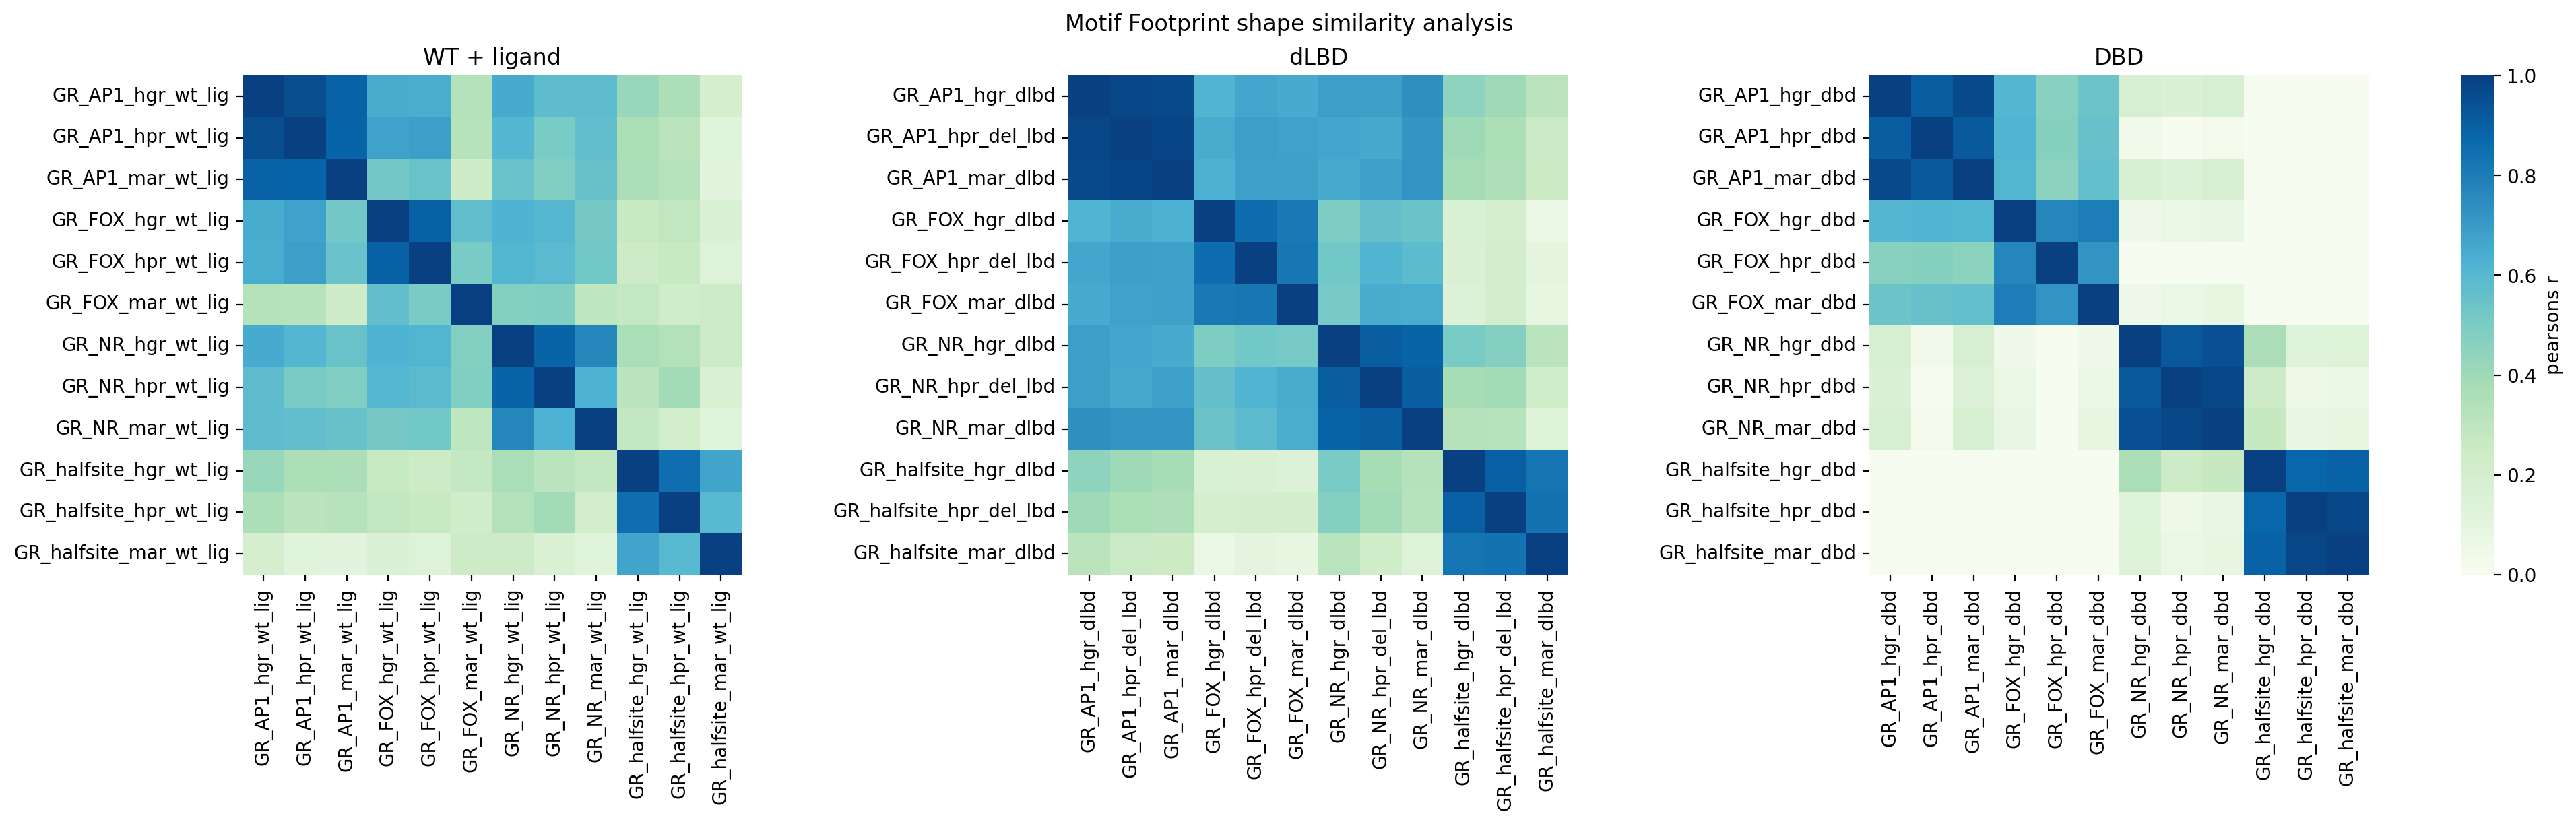

In [9]:
fig, ax = plt.subplots(1,4, figsize=(19,6), constrained_layout=True, width_ratios=[10,10,10,.5])
sns.heatmap(alldf.filter(regex='wt_lig').sort_index(axis=1).corr(), ax=ax[0], cmap='GnBu', cbar=False, vmin=0, vmax=1, square=True)
sns.heatmap(alldf.filter(regex='lbd').sort_index(axis=1).corr(), ax=ax[1], cmap='GnBu', cbar=False, vmin=0, vmax=1, square=True)
sns.heatmap(alldf.filter(regex='dbd').sort_index(axis=1).corr(), ax=ax[2], cmap='GnBu', cbar=True, vmin=0, vmax=1, cbar_ax = ax[-1], square=True, cbar_kws={'label':'pearsons r'})

ax[0].set_title('WT + ligand')
ax[1].set_title('dLBD')
ax[2].set_title('DBD')

fig.suptitle('Motif Footprint shape similarity analysis')

fig.savefig('figures/Fig5/shape_corr_nmumg.pdf')

In [10]:
comp_col = ['GR_halfsite_hpr_del_lbd','GR_halfsite_hgr_dlbd',  'GR_halfsite_mar_dlbd', 'GR_halfsite_hpr_dbd','GR_halfsite_hgr_dbd', 'GR_halfsite_mar_dbd']

Text(0.5, 1.0, 'DBD vs LBD halfsite motif shape similarity')

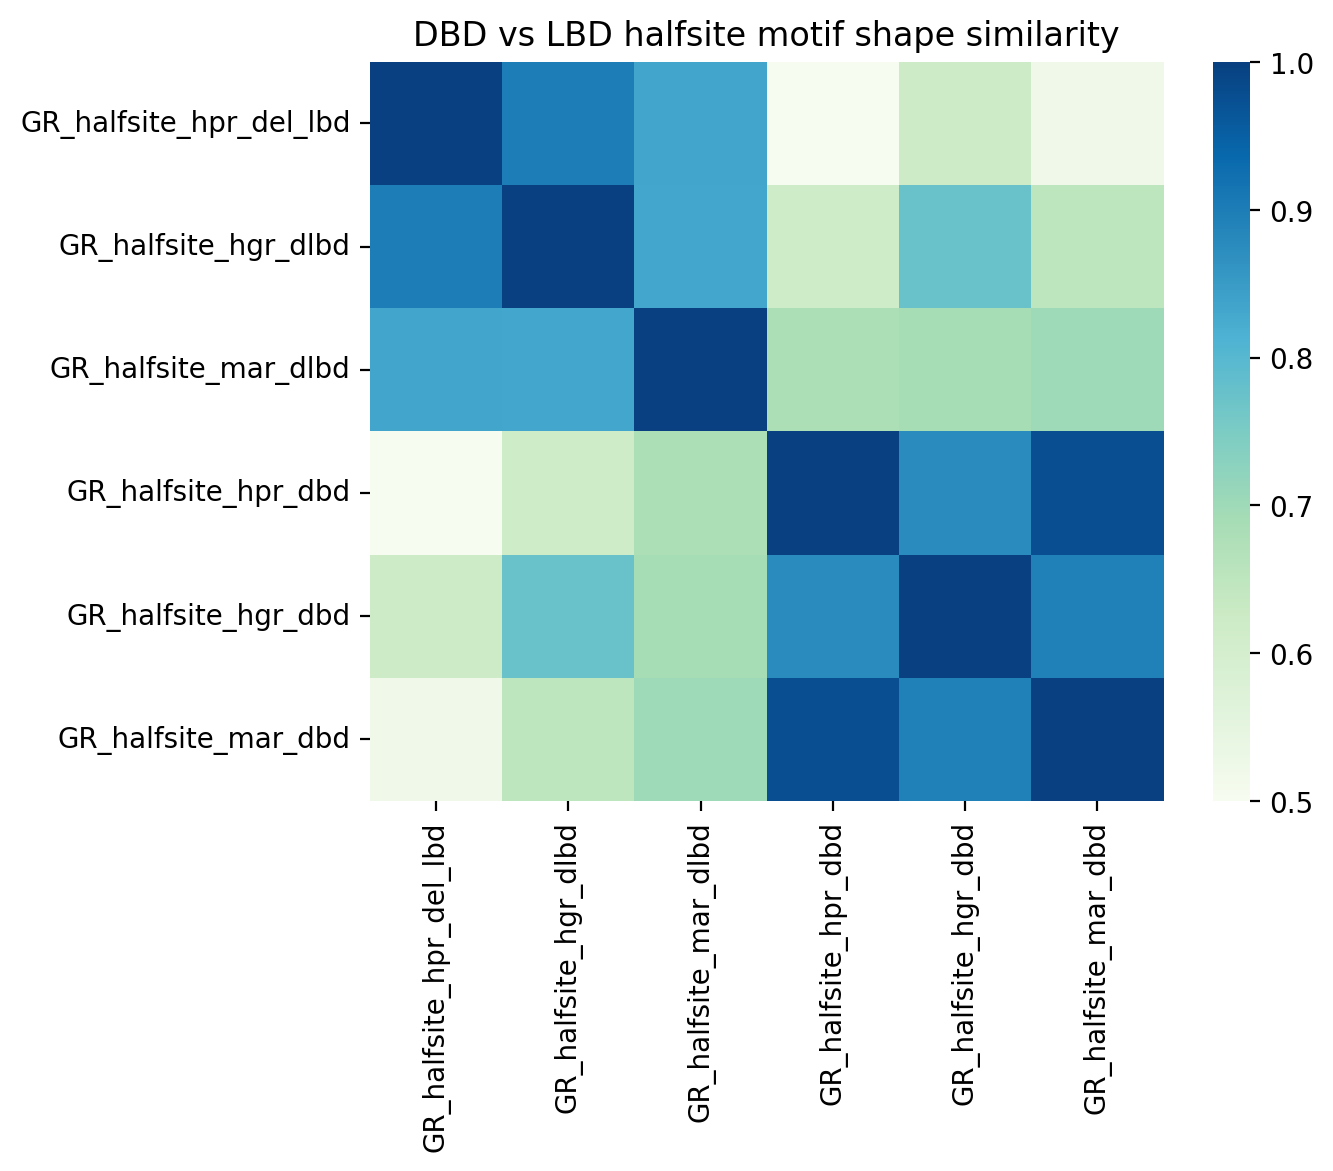

In [11]:
fig, ax = plt.subplots(1)
sns.heatmap(alldf.loc[:, comp_col].corr(), vmin=0.5, cmap='GnBu',ax=ax)
ax.set_title('DBD vs LBD halfsite motif shape similarity')

/tmp/ipykernel_3832095/4100427202.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


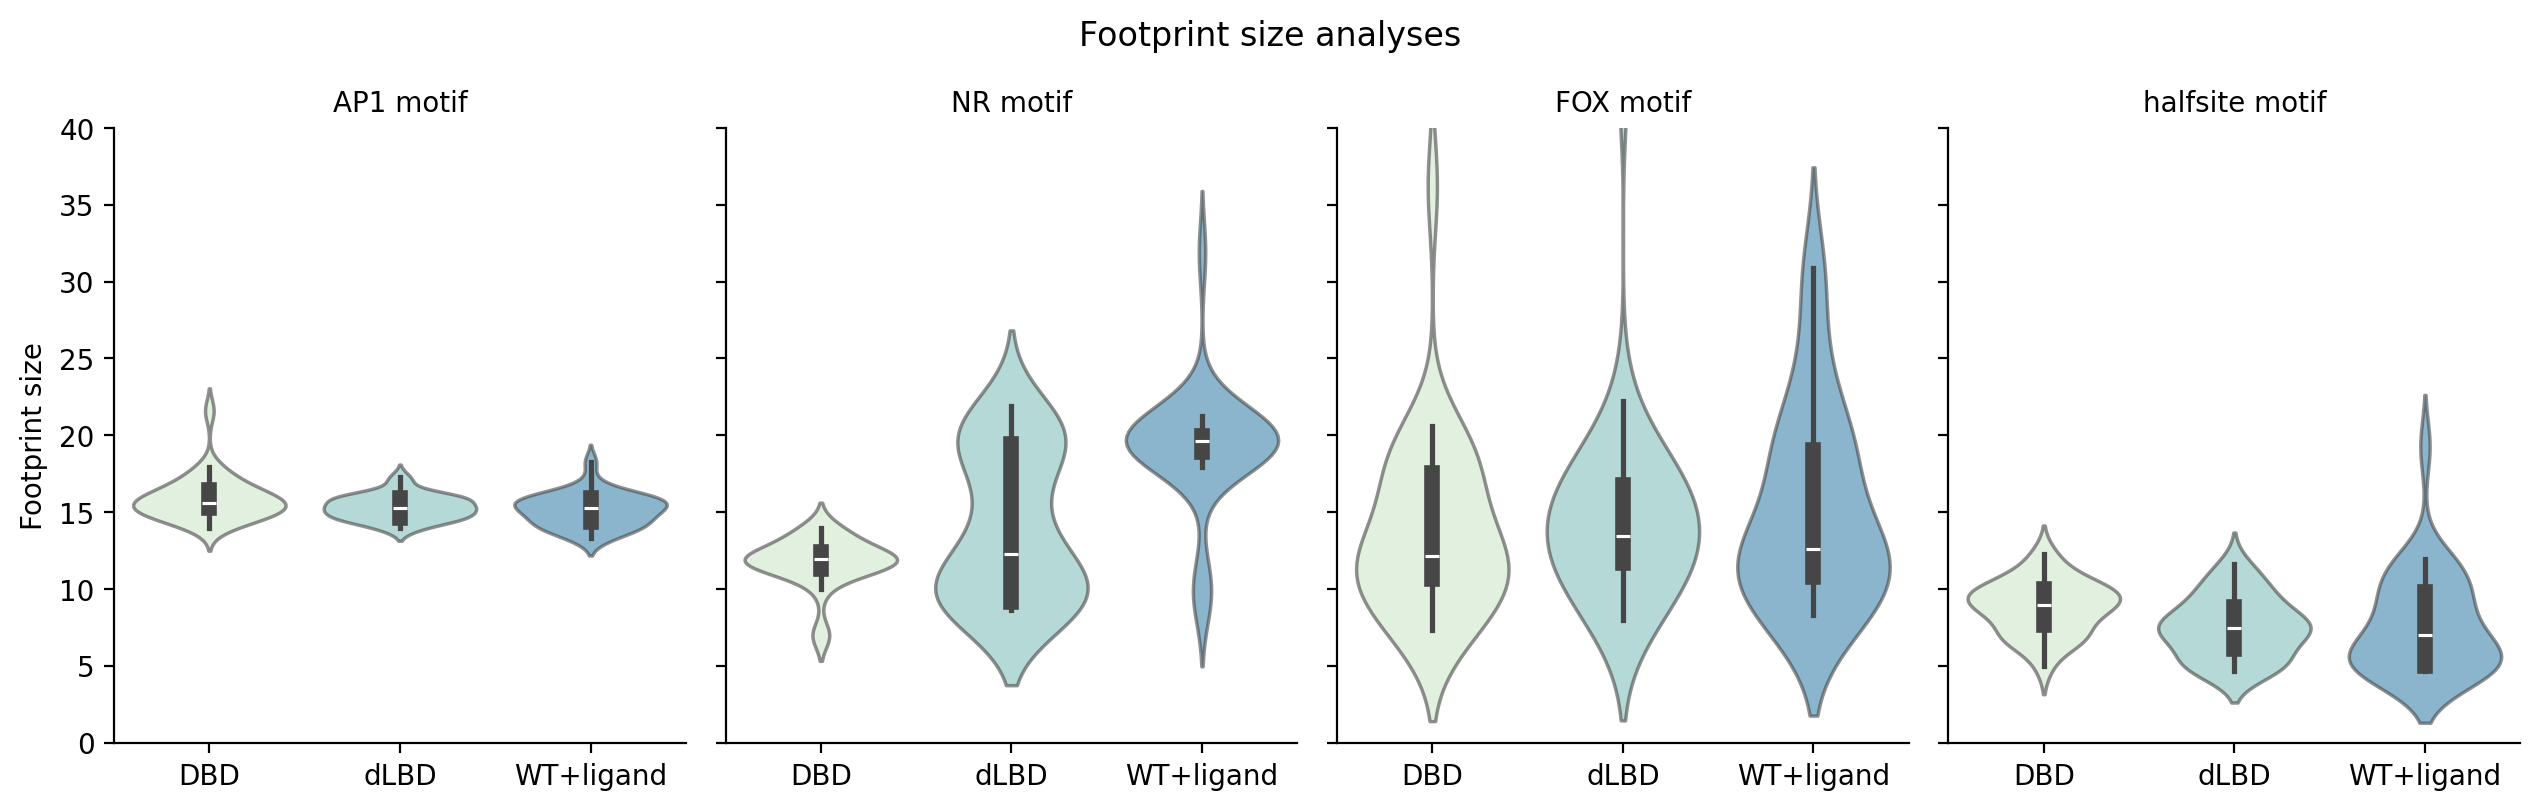

In [17]:
unstacked = allfoot_df.iloc[:10].unstack().reset_index()
unstacked.loc[:, 'motif'] = unstacked.level_0.apply(lambda x: x.split('_')[1])
unstacked.loc[:, 'factor'] = unstacked.level_0.apply(lambda x: '_'.join(x.split('_')[2:]))
unstacked.loc[:, 'type'] = unstacked.factor.apply(lambda x: '_'.join(x.split('_')[1:]))

unstacked = unstacked.drop('level_0', axis=1)
unstacked.replace('del_lbd', 'dlbd', inplace=True)

g = sns.catplot(
    unstacked, kind="violin",
    col="motif", y=0, x="type",
    height=4, aspect=.8, sharey=True,native_scale=True, palette='GnBu', alpha=.6
)
g.set_axis_labels("", "Footprint size")
g.set_xticklabels(["DBD", "dLBD", "WT+ligand"])
g.set_titles("{col_name} {col_var}")
g.fig.suptitle("Footprint size analyses", y=1.05)  # Adjust y to control the vertical position
y_min, y_max = 0, 40  # Define your desired y-axis limits
for ax in g.axes.flat:
    ax.set_ylim(y_min, y_max)
g.figure.savefig('figures/Fig5/shape_violin_nmumg.pdf')

/tmp/ipykernel_3832095/351416869.py:8: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0)
/tmp/ipykernel_3832095/351416869.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_3832095/351416869.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_3832095/351416869.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_3832095/351416869.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplo

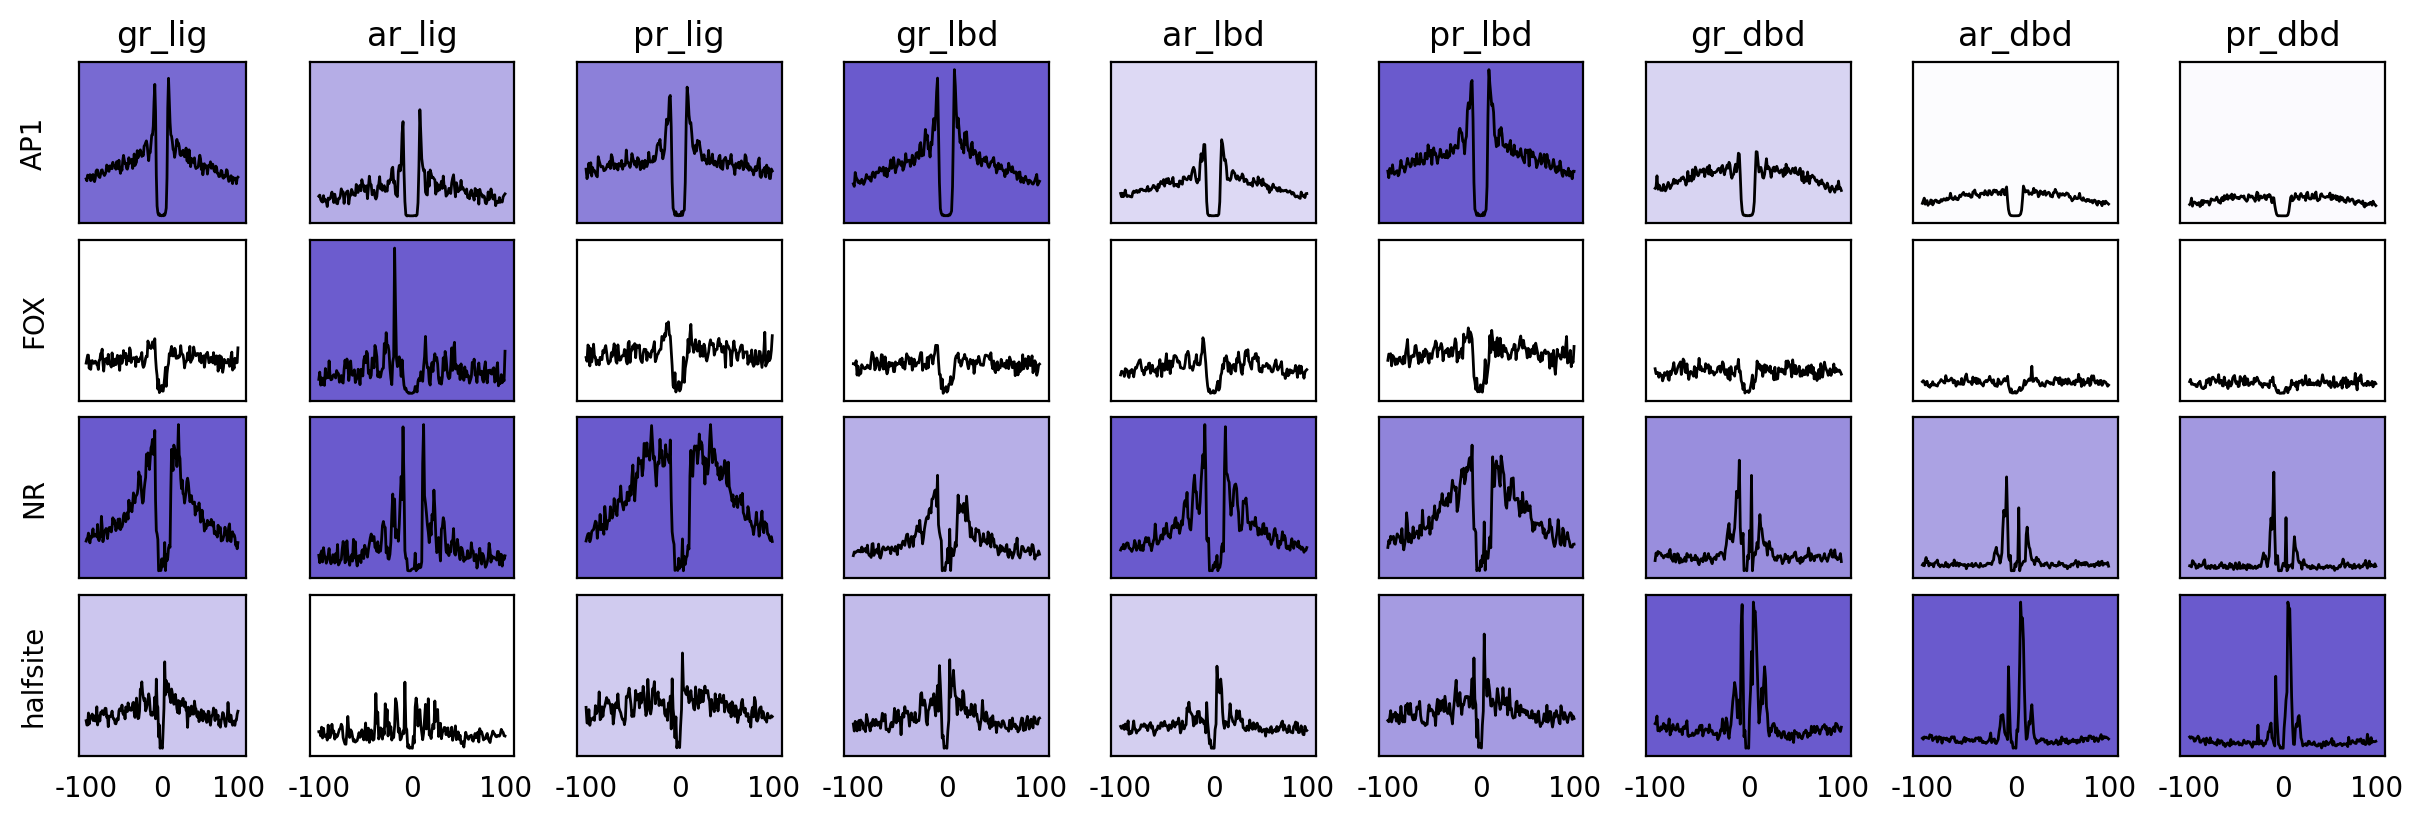

In [18]:
mottype = ['AP1', 'FOX', 'NR', 'halfsite']
tftype =['gr', 'ar', 'pr']
muttype = ['lig', 'lbd', 'dbd']
colormap = sns.blend_palette(['white', 'slateblue'], as_cmap=True)
fig = plt.figure(figsize=(12,4), constrained_layout=True)

subf = fig.subfigures(1,9)
fig.subplots_adjust(wspace=0)
ind = 0

palette = ['purple', 'slateblue', 'palevioletred', 'cadetblue']
for mut in muttype:
    for tf in tftype:
        tfmut = alldf.filter(regex=mut).filter(regex=tf)
        axes = subf[ind].subplots(4,1,sharey=True, sharex=True)
        subf[ind].subplots_adjust(hspace=0)
        axes[0].set_title(f'{tf}_{mut}')
        for mot, axi, c in zip(mottype, axes, palette):
            to_plot = tfmut.filter(regex=mot)
            
            axi.plot(to_plot, c='k', lw=1)
            axi.set_yticklabels('')
            norm = plt.Normalize(vmin=tfmut.max().min(), vmax=tfmut.max().max())
            background_color = colormap(norm(to_plot.max()))
            axi.set_facecolor(background_color)
            axi.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
            if ind == 0:
                axi.set_ylabel(mot)
        axi.set_xticks(np.arange(0,300,100), np.arange(-100,200,100))
        ind += 1
fig.savefig('figures/Fig5/shape_mean_nmumg.pdf')

# Hepg2

In [16]:
# nmeta = pd.read_parquet('sample_metadata_20250211.parquet')
# bgs = nmeta.filter(regex='dbd|lbd$|lig', axis=0).filter(regex='hepg2', axis=0).loc[:, ['NormBG']].T.to_dict()
# mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_hepg2_cluster_parsed/', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_hepg2_cluster_parsed/',
# 'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_hepg2_cluster_parsed/', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_hepg2_cluster_parsed/', ]
# all_motifs = pd.concat([load_mot(x) for x in mot_folders])
# all_motifs.loc[:, 'middle'] = np.ceil(((all_motifs.stop - all_motifs.start)/2) + all_motifs.start).astype(np.int32)
# all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
# remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
# all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
# all_motifs.to_csv('cell_peaks_dbddlbdwtlig/hepg2_motifs_location_in_peaks.csv')

In [19]:
nmeta = pd.read_parquet('sample_metadata_20250211.parquet')
bgs = nmeta.filter(regex='dbd|lbd$|lig', axis=0).filter(regex='hepg2', axis=0).loc[:, ['NormBG']].T.to_dict()
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_hepg2_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_hepg2_cluster_parsed/',
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_hepg2_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_hepg2_cluster_parsed/', ]

motd = {        'GR_NR':    'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif3.motif',
            'GR_halfsite':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif4.motif',
        'GR_FOX':   'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif5.motif',    
        'GR_AP1':   'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif1.motif',
    }

name_path_mot = dict(zip(mot_folders, motd.values()))

all_motifs = pd.concat([load_mot(x, name_path_mot[x]) for x in mot_folders])
all_motifs.loc[:, 'middle'] = np.ceil(((all_motifs.stop - all_motifs.start)/2) + all_motifs.start).astype(np.int32)
all_motifs = all_motifs.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'middle']]
all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
all_motifs.to_csv('cell_peaks_dbddlbdwtlig/hepg2_motifs_location_in_peaks.csv')

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [20]:
procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/hepg2_motifs_location_in_peaks.csv --output {out}\"'

for key, value in bgs.items():
    out = "cell_peaks_dbddlbdwtlig/{}".format(key)
    print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/HepG2_AR_DBD_1_S34.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/HepG2_AR_DBD_3_S36.bedgraph.gz --motifs cell_peaks_dbddlbdwtlig/hepg2_motifs_location_in_peaks.csv --output cell_peaks_dbddlbdwtlig/hepg2_ar_dbd"
bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/HepG2_AR_WT_lig_1_S16.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/HepG2_AR_WT_lig_2_S17.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/HepG2_AR_WT_lig_3_S18.bedgraph.gz --motifs cell_pe

In [21]:
mot_signals = sorted(glob.glob('cell_peaks_dbddlbdwtlig/hepg2*signals_on_motifs.parquet'))

alldf = pd.DataFrame()
allfoot_df = pd.DataFrame()
for sig in mot_signals:
    a = pd.read_parquet(sig)
    analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))]
    foot_df = pd.DataFrame()
    for idi in analyzed.id.unique():
        proc_df = filter_top_quantile(analyzed[analyzed.id == idi].loc[:, np.arange(200).astype(str)], 0.9)
        top5_cols = (
                proc_df.iloc[:, :200]
                .mean()
                .sort_values(ascending=False)
                .iloc[:5]
                .index
                .astype(int)
            )
        null = proc_df.iloc[:, top5_cols].values.flatten()
        func = lambda x: stats.mannwhitneyu(null, x)[1]
        calc_pvs = proc_df.iloc[:, :200].apply(func, axis=0)
        calc_pvs[(calc_pvs == 0)] = calc_pvs[~(calc_pvs == 0)].min()
        m10log10pval = (-10 * np.log10(calc_pvs))
        
        foot  = pd.DataFrame(compute_footprint_lengths(m10log10pval.index.astype(int), m10log10pval, np.arange(0.05,1.05,0.05)), index=[idi]).T
        foot_df = pd.concat([foot_df, foot], axis=1)
    analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
    analyzed.columns = [x+ '_' + sig.split('/')[-1].split('_signals')[0].replace('GR_', '') for x in analyzed.columns]
    foot_df.columns = [x+ '_' + sig.split('/')[-1].split('_signals')[0].replace('GR_', '') for x in foot_df.columns]

    alldf = pd.concat([alldf, analyzed], axis=1)
    allfoot_df = pd.concat([allfoot_df, foot_df], axis=1)

/tmp/ipykernel_3832095/1195302456.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_3832095/1195302456.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_3832095

/tmp/ipykernel_3832095/3186187889.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_3832095/3186187889.py:43: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0)
/tmp/ipykernel_3832095/3186187889.py:51: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_3832095/3186187889.py:51: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_3832095/3186187889.py:51: UserWarning: This figure was using a layout engine that 

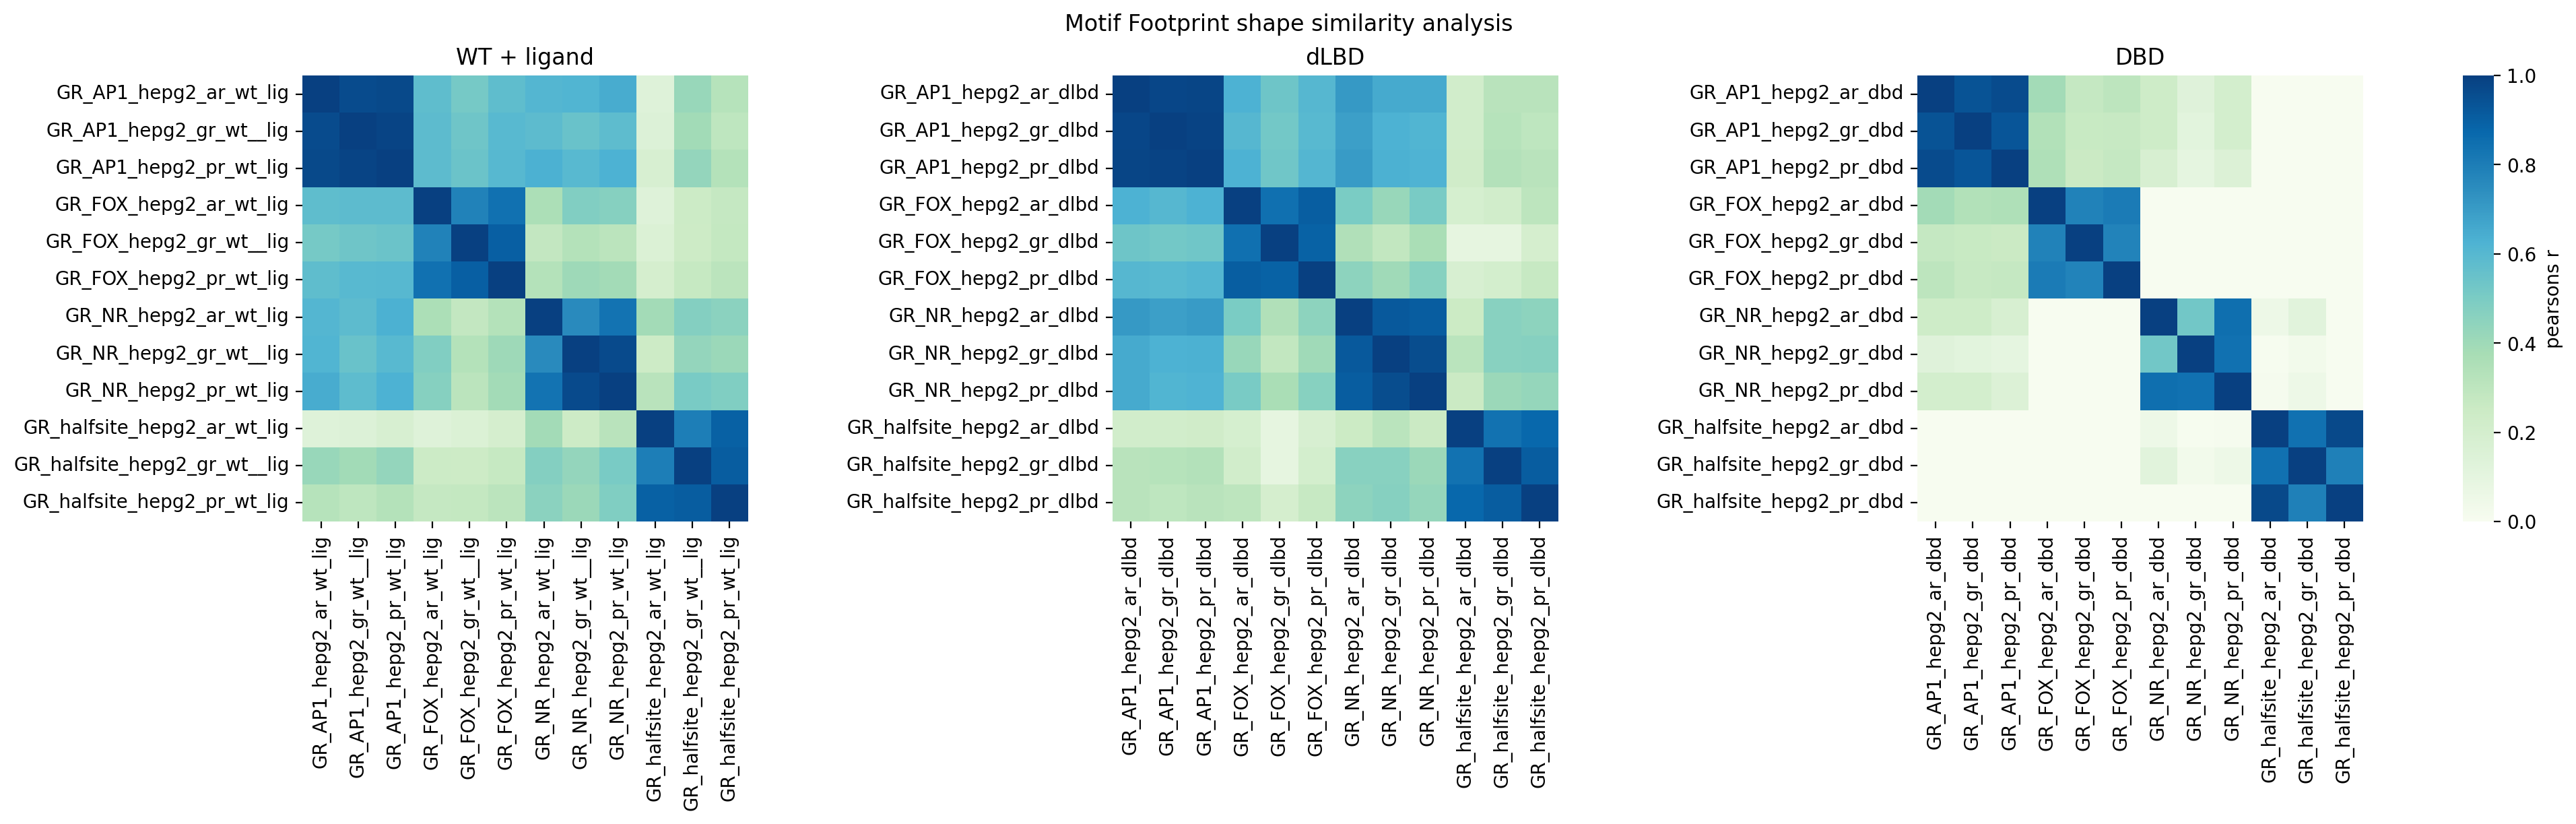

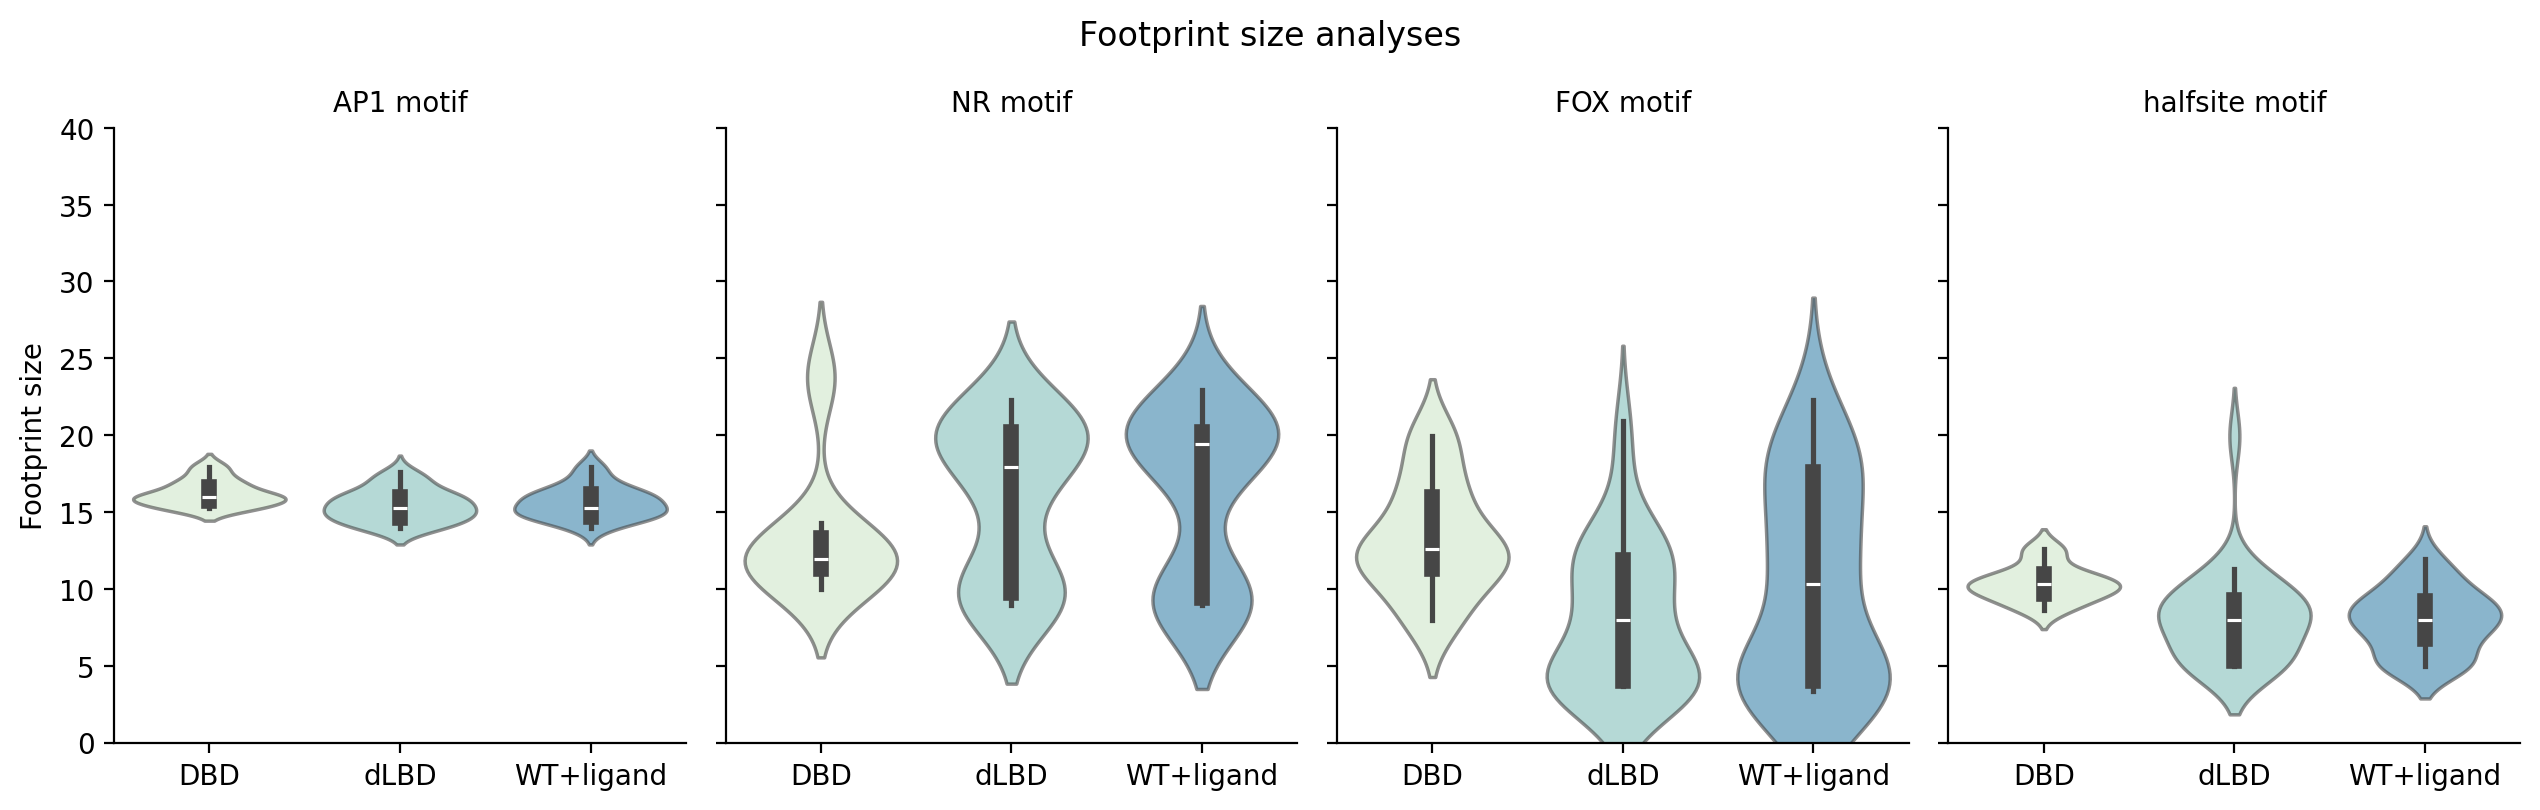

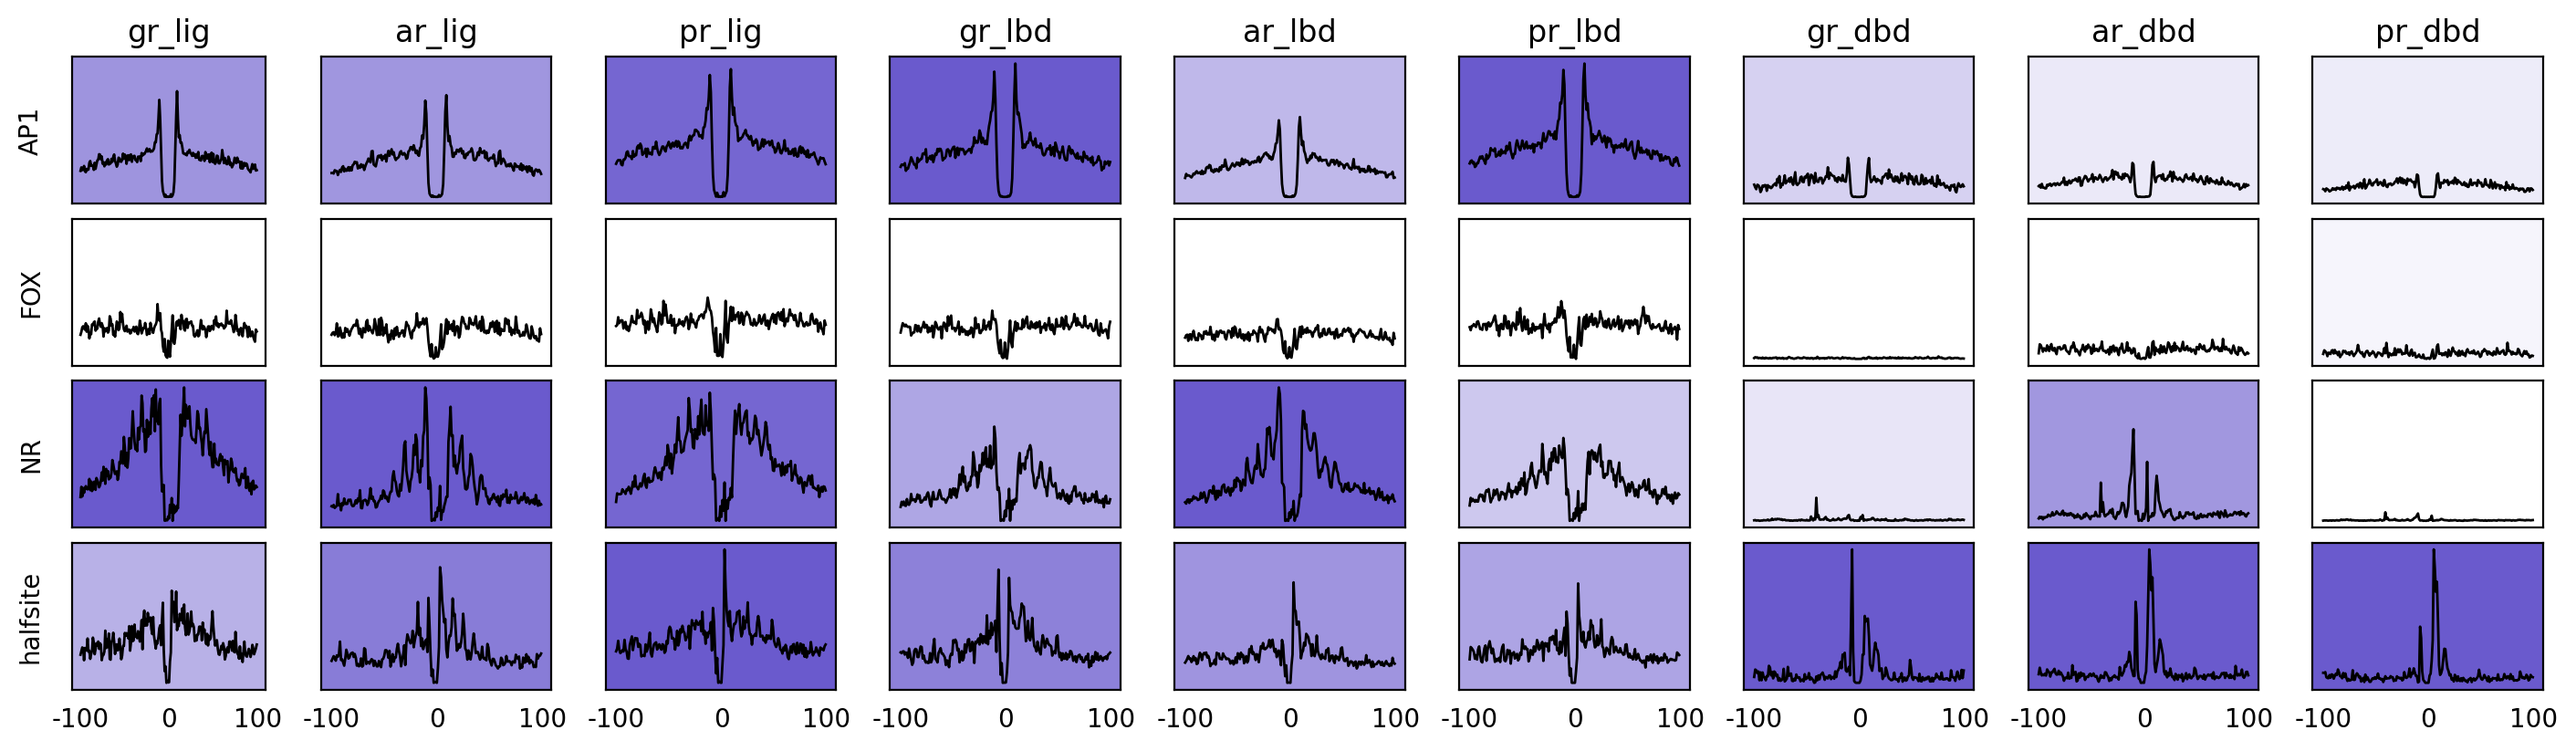

In [23]:
fig, ax = plt.subplots(1,4, figsize=(19,6), constrained_layout=True, width_ratios=[10,10,10,.5])
sns.heatmap(alldf.filter(regex='lig').sort_index(axis=1).corr(), ax=ax[0], cmap='GnBu', cbar=False, vmin=0, vmax=1, square=True)
sns.heatmap(alldf.filter(regex='lbd').sort_index(axis=1).corr(), ax=ax[1], cmap='GnBu', cbar=False, vmin=0, vmax=1, square=True)
sns.heatmap(alldf.filter(regex='dbd').sort_index(axis=1).corr(), ax=ax[2], cmap='GnBu', cbar=True, vmin=0, vmax=1, cbar_ax = ax[-1], square=True, cbar_kws={'label':'pearsons r'})

ax[0].set_title('WT + ligand')
ax[1].set_title('dLBD')
ax[2].set_title('DBD')

fig.suptitle('Motif Footprint shape similarity analysis')

fig.savefig('figures/Fig5/shape_corr_hepg2.pdf')

unstacked = allfoot_df.iloc[:10].unstack().reset_index()
unstacked.loc[:, 'motif'] = unstacked.level_0.apply(lambda x: x.split('_')[1])
unstacked.loc[:, 'factor'] = unstacked.level_0.apply(lambda x: '_'.join(x.split('_')[3:]))
unstacked.loc[:, 'type'] = unstacked.factor.apply(lambda x: x.split('_')[-1])
unstacked

unstacked = unstacked.drop('level_0', axis=1)

g = sns.catplot(
    unstacked, kind="violin",
    col="motif", y=0, x="type",
    height=4, aspect=.8, sharey=True,native_scale=True, palette='GnBu', alpha=.6
)
g.set_axis_labels("", "Footprint size")
g.set_xticklabels(["DBD", "dLBD", "WT+ligand"])
g.set_titles("{col_name} {col_var}")
g.fig.suptitle("Footprint size analyses", y=1.05)  # Adjust y to control the vertical position
y_min, y_max = 0, 40  # Define your desired y-axis limits
for ax in g.axes.flat:
    ax.set_ylim(y_min, y_max)
g.figure.savefig('figures/Fig5/shape_violin_hepg2.pdf')

mottype = ['AP1', 'FOX', 'NR', 'halfsite']
tftype =['gr', 'ar', 'pr']
muttype = ['lig', 'lbd', 'dbd']
colormap = sns.blend_palette(['white', 'slateblue'], as_cmap=True)
fig = plt.figure(figsize=(14,4), constrained_layout=True)

subf = fig.subfigures(1,9)
fig.subplots_adjust(wspace=0)
ind = 0

palette = ['purple', 'slateblue', 'palevioletred', 'cadetblue']
for mut in muttype:
    for tf in tftype:
        tfmut = alldf.filter(regex=mut).filter(regex=tf)
        axes = subf[ind].subplots(4,1,sharey=True, sharex=True)
        subf[ind].subplots_adjust(hspace=0)
        axes[0].set_title(f'{tf}_{mut}')
        for mot, axi, c in zip(mottype, axes, palette):
            to_plot = tfmut.filter(regex=mot)
            
            axi.plot(to_plot, c='k', lw=1)
            axi.set_yticklabels('')
            norm = plt.Normalize(vmin=tfmut.max().min(), vmax=tfmut.max().max())
            background_color = colormap(norm(to_plot.max()))
            axi.set_facecolor(background_color)
            axi.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
            if ind == 0:
                axi.set_ylabel(mot)
        axi.set_xticks(np.arange(0,300,100), np.arange(-100,200,100))
        ind += 1
fig.savefig('figures/Fig5/shape_mean_hepg2.pdf')


# MCF7

In [24]:
nmeta = pd.read_parquet('sample_metadata_20250211.parquet')
bgs = nmeta.filter(regex='dbd|lbd$|lig', axis=0).filter(regex='mcf7', axis=0).loc[:, ['NormBG']].T.to_dict()
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_mcf7_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_mcf7_cluster_parsed/',
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_mcf7_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_mcf7_cluster_parsed/', ]
motd = {        'GR_NR':    'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif3.motif',
            'GR_halfsite':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif4.motif',
        'GR_FOX':   'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif5.motif',    
        'GR_AP1':   'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif1.motif',
    }

name_path_mot = dict(zip(mot_folders, motd.values()))

all_motifs = pd.concat([load_mot(x, name_path_mot[x]) for x in mot_folders])
all_motifs.loc[:, 'middle'] = np.ceil(((all_motifs.stop - all_motifs.start)/2) + all_motifs.start).astype(np.int32)
all_motifs = all_motifs.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'middle']]
all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
all_motifs.to_csv('cell_peaks_dbddlbdwtlig/mcf7_motifs_location_in_peaks.csv')

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [25]:
procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/mcf7_motifs_location_in_peaks.csv --output {out}\"'

for key, value in bgs.items():
    out = "cell_peaks_dbddlbdwtlig/{}".format(key)
    print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/MCF7_AR_WT_lig_1_S70.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/MCF7_AR_WT_lig_2_S71.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/MCF7_AR_WT_lig_3_S72.bedgraph.gz --motifs cell_peaks_dbddlbdwtlig/mcf7_motifs_location_in_peaks.csv --output cell_peaks_dbddlbdwtlig/mcf7_ar_wt_lig"
bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/MCF7_GR_DBD_1_S79.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20240716_MCF7_HepG2_andmore/results/bedgraphs/MCF7_GR_DBD_2_S80.bedgraph.gz /home/labs/barkailab

In [26]:
mot_signals = sorted(glob.glob('cell_peaks_dbddlbdwtlig/mcf7*signals_on_motifs.parquet'))
alldf = pd.DataFrame()
allfoot_df = pd.DataFrame()
for sig in mot_signals:
    a = pd.read_parquet(sig)
    analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))]
    foot_df = pd.DataFrame()
    for idi in analyzed.id.unique():
        proc_df = filter_top_quantile(analyzed[analyzed.id == idi].loc[:, np.arange(200).astype(str)], 0.5)
        top5_cols = (
                proc_df.iloc[:, :200]
                .mean()
                .sort_values(ascending=False)
                .iloc[:5]
                .index
                .astype(int)
            )
        null = proc_df.iloc[:, top5_cols].values.flatten()
        func = lambda x: stats.mannwhitneyu(null, x)[1]
        calc_pvs = proc_df.iloc[:, :200].apply(func, axis=0)
        calc_pvs[(calc_pvs == 0)] = calc_pvs[~(calc_pvs == 0)].min()
        m10log10pval = (-10 * np.log10(calc_pvs))
        
        foot  = pd.DataFrame(compute_footprint_lengths(m10log10pval.index.astype(int), m10log10pval, np.arange(0.05,1.05,0.05)), index=[idi]).T
        foot_df = pd.concat([foot_df, foot], axis=1)
    analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.5).groupby('id').mean().T
    analyzed.columns = [x+ '_' + sig.split('/')[-1].split('_signals')[0].replace('GR_', '') for x in analyzed.columns]
    foot_df.columns = [x+ '_' + sig.split('/')[-1].split('_signals')[0].replace('GR_', '') for x in foot_df.columns]

    alldf = pd.concat([alldf, analyzed], axis=1)
    allfoot_df = pd.concat([allfoot_df, foot_df], axis=1)

/tmp/ipykernel_3832095/279249999.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.5).groupby('id').mean().T
/tmp/ipykernel_3832095/279249999.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.5).groupby('id').mean().T
/tmp/ipykernel_3832095/2

/tmp/ipykernel_3832095/3899794511.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_3832095/3899794511.py:43: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0)
/tmp/ipykernel_3832095/3899794511.py:54: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_3832095/3899794511.py:54: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_3832095/3899794511.py:54: UserWarning: This figure was using a layout engine that 

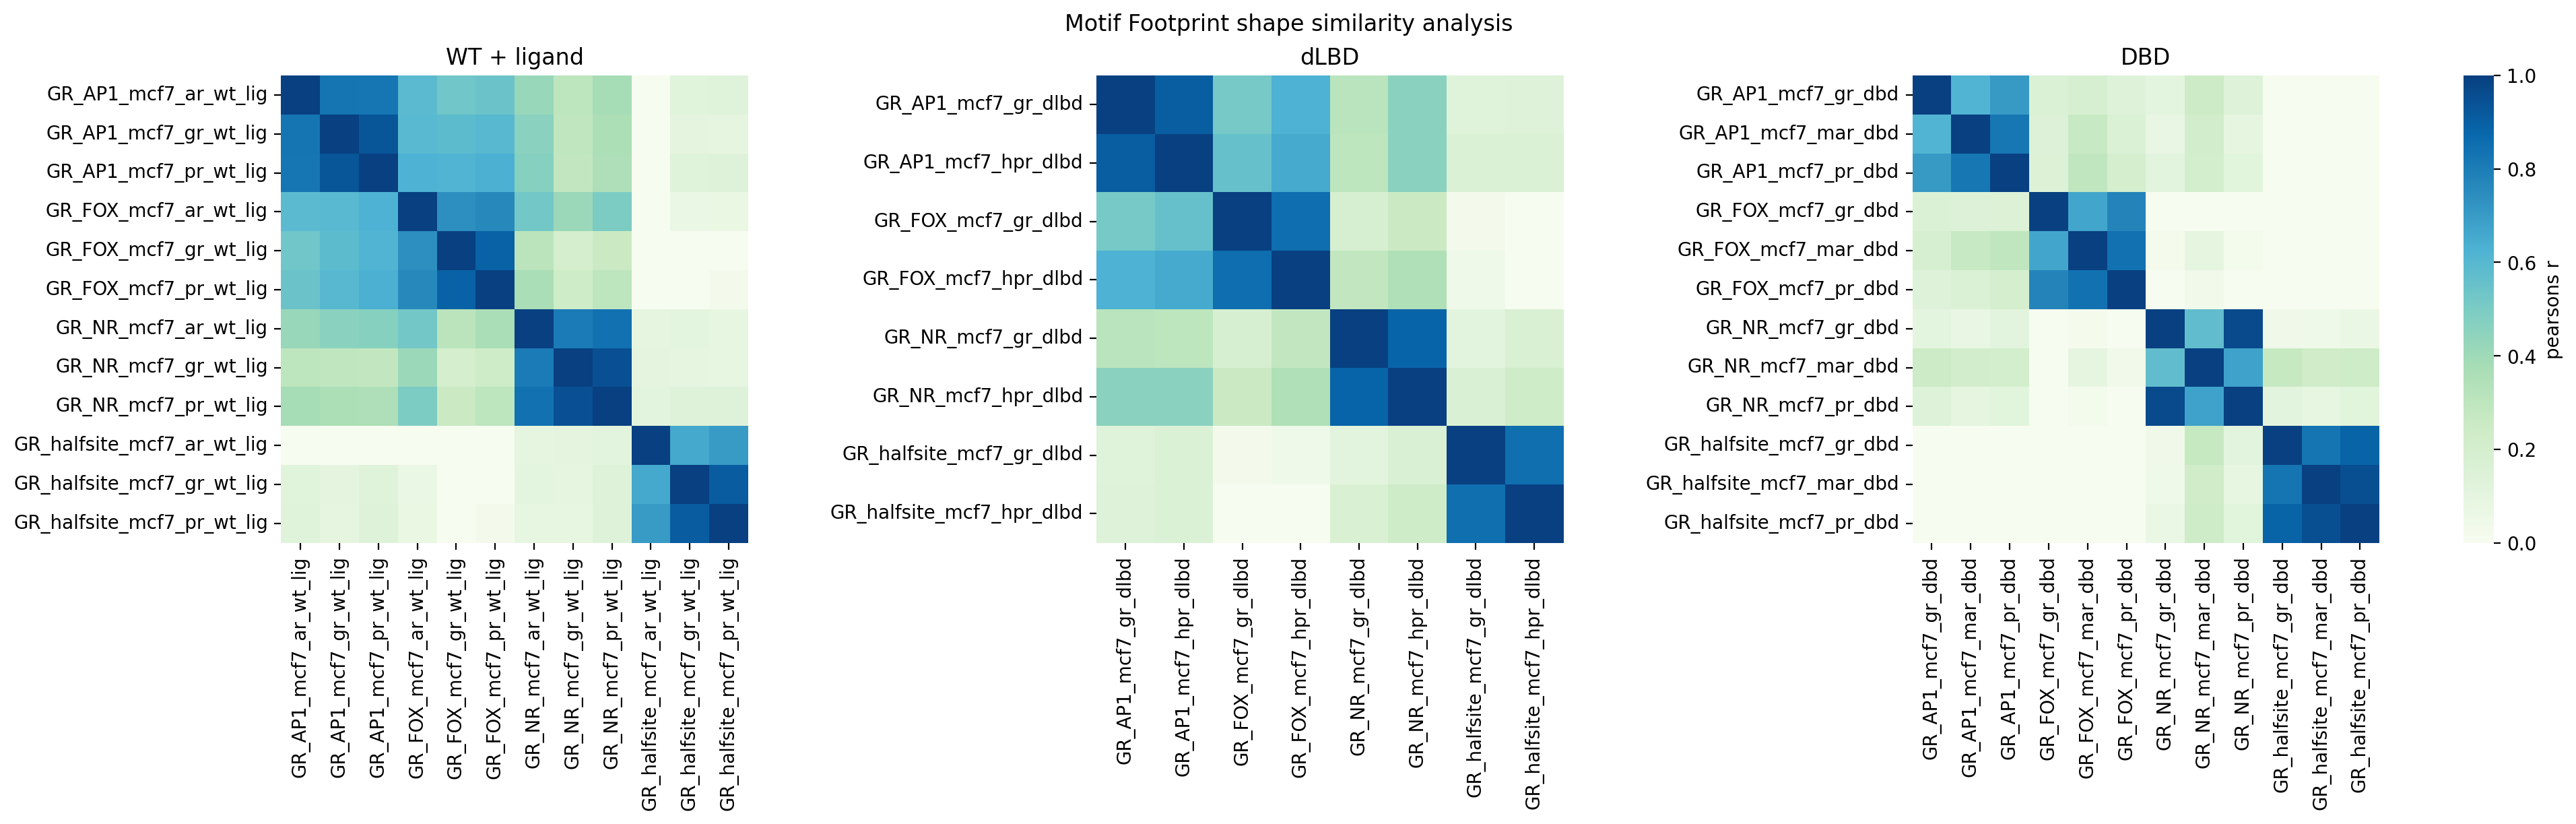

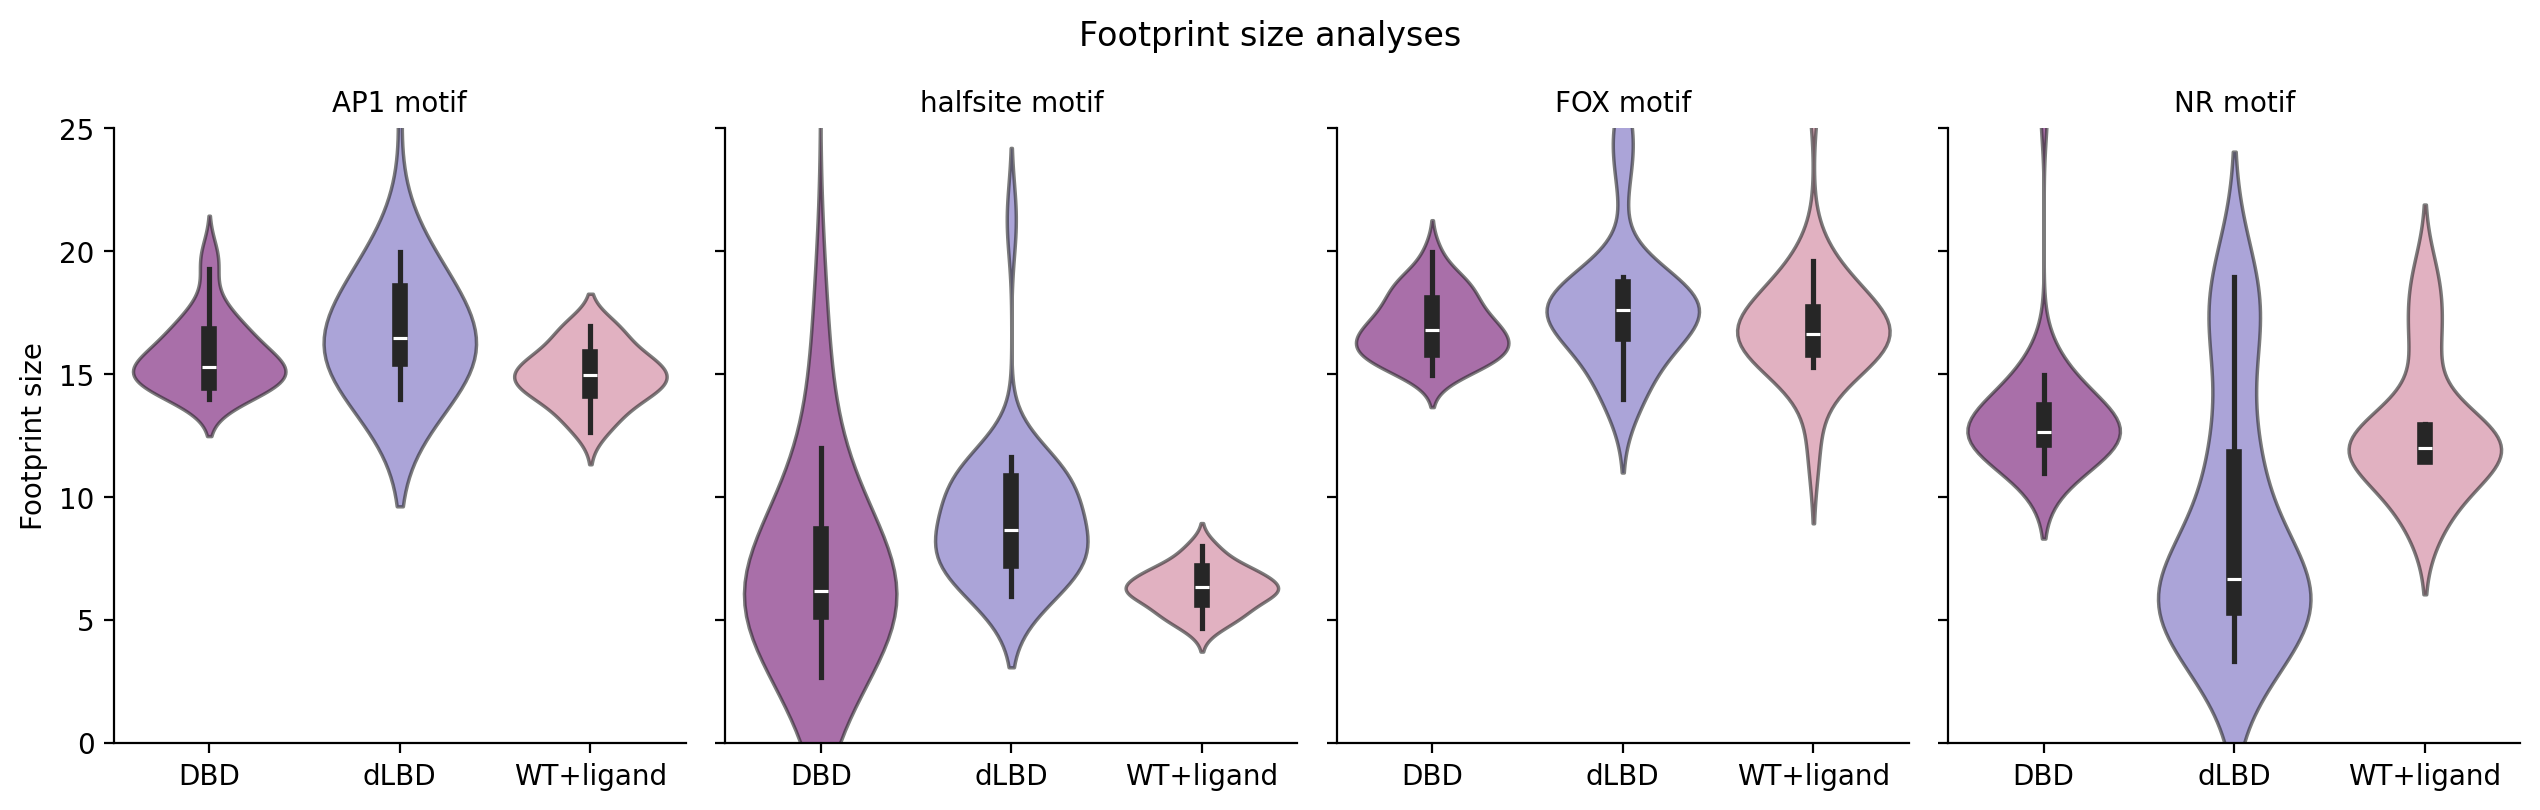

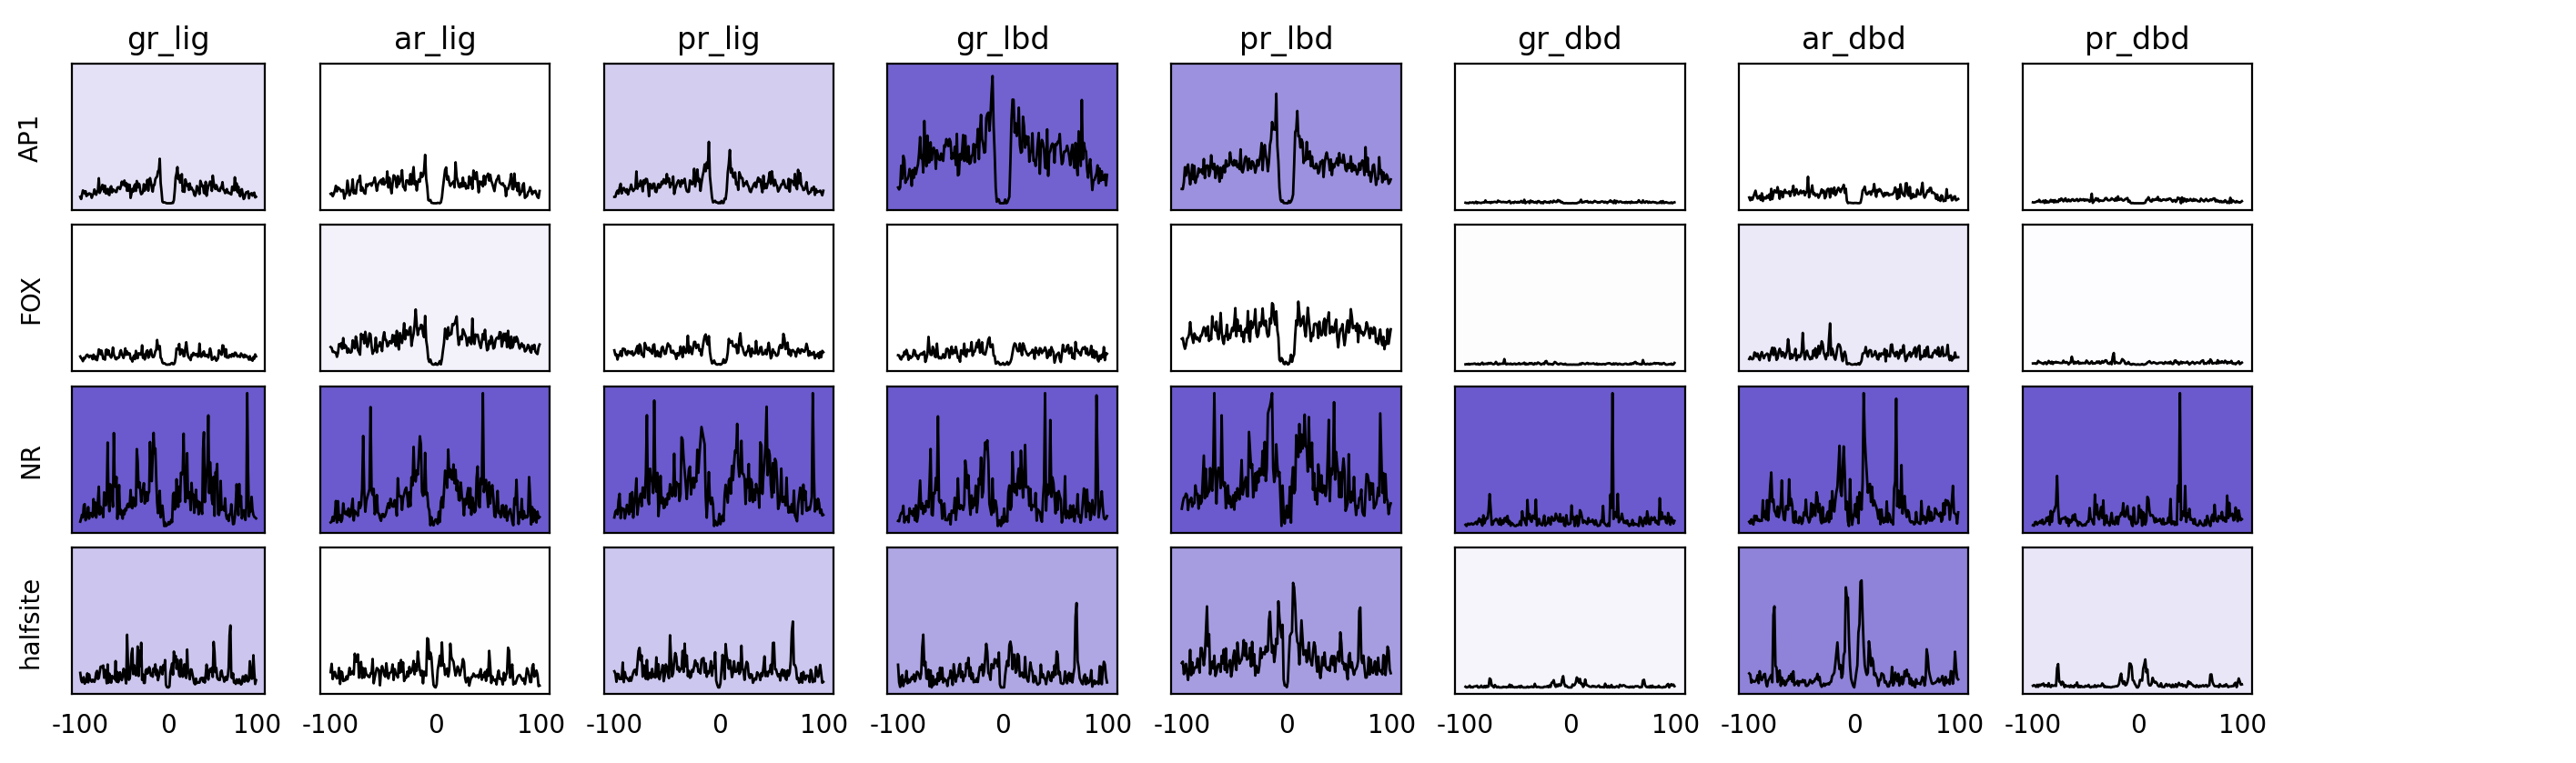

In [27]:
fig, ax = plt.subplots(1,4, figsize=(19,6), constrained_layout=True, width_ratios=[10,10,10,.5])
sns.heatmap(alldf.filter(regex='lig').sort_index(axis=1).corr(), ax=ax[0], cmap='GnBu', cbar=False, vmin=0, vmax=1, square=True)
sns.heatmap(alldf.filter(regex='lbd').sort_index(axis=1).corr(), ax=ax[1], cmap='GnBu', cbar=False, vmin=0, vmax=1, square=True)
sns.heatmap(alldf.filter(regex='dbd').sort_index(axis=1).corr(), ax=ax[2], cmap='GnBu', cbar=True, vmin=0, vmax=1, cbar_ax = ax[-1], square=True, cbar_kws={'label':'pearsons r'})

ax[0].set_title('WT + ligand')
ax[1].set_title('dLBD')
ax[2].set_title('DBD')

fig.suptitle('Motif Footprint shape similarity analysis')

fig.savefig('figures/Fig5/shape_corr_mcf7.pdf')

unstacked = allfoot_df.iloc[:10].unstack().reset_index()
unstacked.loc[:, 'motif'] = unstacked.level_0.apply(lambda x: x.split('_')[1])
unstacked.loc[:, 'factor'] = unstacked.level_0.apply(lambda x: '_'.join(x.split('_')[3:]))
unstacked.loc[:, 'type'] = unstacked.factor.apply(lambda x: x.split('_')[-1])
unstacked

unstacked = unstacked.drop('level_0', axis=1)

g = sns.catplot(
    unstacked, kind="violin",
    col="motif", y=0, x="type",
    height=4, aspect=.8, sharey=True,native_scale=True, palette=['purple', 'slateblue', 'palevioletred'], alpha=.6
)
g.set_axis_labels("", "Footprint size")
g.set_xticklabels(["DBD", "dLBD", "WT+ligand"])
g.set_titles("{col_name} {col_var}")
g.fig.suptitle("Footprint size analyses", y=1.05)  # Adjust y to control the vertical position
y_min, y_max = 0, 25  # Define your desired y-axis limits
for ax in g.axes.flat:
    ax.set_ylim(y_min, y_max)
g.figure.savefig('figures/Fig5/shape_violin_mcf7.pdf')

mottype = ['AP1', 'FOX', 'NR', 'halfsite']
tftype =['gr', 'ar', 'pr']
muttype = ['lig', 'lbd', 'dbd']
colormap = sns.blend_palette(['white', 'slateblue'], as_cmap=True)
fig = plt.figure(figsize=(14,4), constrained_layout=True)

subf = fig.subfigures(1,9)
fig.subplots_adjust(wspace=0)
ind = 0

palette = ['purple', 'slateblue', 'palevioletred', 'cadetblue']
for mut in muttype:
    for tf in tftype:
        if mut == 'lbd' and tf == 'ar':
            continue
        
        tfmut = alldf.filter(regex=mut).filter(regex=tf)
        axes = subf[ind].subplots(4,1,sharey=True, sharex=True)
        subf[ind].subplots_adjust(hspace=0)
        axes[0].set_title(f'{tf}_{mut}')
        for mot, axi, c in zip(mottype, axes, palette):
            to_plot = tfmut.filter(regex=mot)
            
            axi.plot(to_plot, c='k', lw=1)
            axi.set_yticklabels('')
            norm = plt.Normalize(vmin=tfmut.max().min(), vmax=tfmut.max().max())
            background_color = colormap(norm(to_plot.max()))
            axi.set_facecolor(background_color)
            axi.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
            if ind == 0:
                axi.set_ylabel(mot)
        axi.set_xticks(np.arange(0,300,100), np.arange(-100,200,100))
        ind += 1
fig.savefig('figures/Fig5/shape_mean_mcf7.pdf')
